# Community/Subreddit Embedding

In [1]:
import findspark
findspark.init("/h/224/cameron/spark-3.0.0-preview2-bin-hadoop2.7")
from kaleido.scopes.plotly import PlotlyScope
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile

scope = PlotlyScope()


Bad key "text.kerning_factor" on line 4 in
/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'adavm1.ais.sandbox'),
 ('spark.driver.memory', '400g'),
 ('spark.driver.port', '46859'),
 ('spark.shuffle.memoryFraction', '0.8'),
 ('spark.app.id', 'local-1599495864719'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.sql.shuffle.partitions', '32'),
 ('spark.default.parallelism', '50'),
 ('spark.local.dir', '/h/224/cameron/SPARK-LOCAL-DIR'),
 ('spark.executor.memory', '400g'),
 ('spark.storage.memoryFraction', '0.1'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.executor.cores', '16'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

## Word2Vecf Files
[Word2vecf](https://github.com/BIU-NLP/word2vecf/blob/master/README.md) requires three inputs
* training_data: text file of word-context pairs (space delimited)
* word_vocabulary: file mapping subreddits (strings) to their counts
* count_vocabulary: file mapping users (contexts -> subreddit commenters) to their counts

### Training Data

We want to avoid having to load the raw data as there are 1 billion+ rows. Working with aggregates from the start makes things much easier.

In [5]:
# Load the Parquet data
comments = spark.read.load("/comments_2019.parquet")
training_data = comments.fillna("").groupBy("subreddit","author").count().cache()
training_data.show()

+------------------+--------------------+-----+
|         subreddit|              author|count|
+------------------+--------------------+-----+
|               wsb|            oncutter|    2|
|       apexlegends|IShouldWashTheDishes|   83|
|      glassanimals|            willzore|   47|
|         femalepov|         inter260799|    1|
|   entitledparents|         viscool8332| 1008|
|   leagueoflegends|     TehRudeSandstrm| 1800|
|             ReBBl|              Breidr|   65|
|  ApexLegends_Porn|       AutoModerator|   45|
|               DnD|           harumin24|   22|
|              kpop|          BlueFiller|  233|
|            chubby|        horny_as_fuq|  114|
|       ihadastroke|             Phhhhuh|    1|
|             japan|          voidgazing|   10|
|elderscrollsonline|    the_scarlet_ibis|   71|
|WhitePeopleTwitter|          teenytanya|    1|
|       TaylorSwift|sparklejumprop3queen|   91|
|      BattlefieldV|      Extra-High-Elf|  714|
|     AmItheAsshole|    SilvergillAddict

In [ ]:
comments.count()

### Word Vocabulary

In [3]:
basketball = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/validation/basketball.csv").to_numpy().flatten())
baseball = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/validation/baseball.csv").to_numpy().flatten())
football = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/validation/football.csv").to_numpy().flatten())
hockey = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/validation/hockey.csv").to_numpy().flatten())
cities = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/validation/populous_cities.csv").to_numpy().flatten())
unis = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/validation/uni_to_city.csv").to_numpy().flatten())
political_subreddits = ["antiwar","peace","Christianity","exchristian","TraditionalCatholics","excatholic","lds","exmormon","islam","exmuslim",
        "Conservative","progressive","Republican","democrats","conservatives","SocialDemocracy",
        "TheNewRight","WeAreNotAsking","antifeminists","Feminism","prolife","prochoice","prolife","birthcontrol",
        "progun","GunsAreCool","datingoverforty","teenagers","RedditForGrownups","teenagersnew",
        "CredibleDefense","EndlessWar","WarCollege","EndlessWar","Intelligence","EndlessWar",
        "neoliberal","LateStageImperialism","Economics","capitalism_in_decay",
        "JoeBiden","SandersForPresident","BaemyKlobaechar","ElizabethWarren","Pete_Buttigieg",
        "YangForPresidentHQ","The_Donald","SocialDemocracy","Classical_Liberals","benshapiro","walkaway",
        "FreeSpeech","dsa","ConservativeDemocrat"]
subs_to_keep = tuple(np.unique(basketball+baseball+football+hockey+cities+unis+political_subreddits))
subs_to_keep

('49ers',
 'ASU',
 'AZCardinals',
 'Adelaide',
 'Alabama',
 'Albany',
 'Albuquerque',
 'Algonquin_College',
 'AllHail',
 'AmericanU',
 'AndersonSC',
 'AndersonUniversity',
 'AnnArbor',
 'Annapolis',
 'Anu',
 'Appleton',
 'Arcata',
 'Arkansas',
 'ArkansasState',
 'Astros',
 'Athens',
 'Atlanta',
 'AtlantaHawks',
 'Austin',
 'BCIT',
 'BGOhio',
 'BGSU',
 'Babson',
 'BaemyKlobaechar',
 'BallState',
 'Baruch',
 'Bath',
 'BathUni',
 'BeckleyOnReddit',
 'Belfast',
 'Bellingham',
 'Berklee',
 'Binghamton',
 'BinghamtonUniversity',
 'Birmingham',
 'BloomingtonNormal',
 'BlueJackets',
 'BocaRaton',
 'Boise',
 'BostonBruins',
 'BostonU',
 'BournemouthUni',
 'BowlingGreen',
 'Bozeman',
 'Braves',
 'Brewers',
 'BritishKent',
 'Broward',
 'BrownU',
 'Browns',
 'Buffalo',
 'CCA',
 'CCCU',
 'CCNY',
 'CHIBears',
 'CHICubs',
 'CNU',
 'CSUC',
 'CSUDH',
 'CSUEB',
 'CSUFoCo',
 'CSULA',
 'CSULB',
 'CSUS',
 'CSUSB',
 'CUNY',
 'CalPoly',
 'CalPolyPomona',
 'Calgary',
 'CalgaryFlames',
 'California',
 'Caltech

In [6]:
from pyspark.sql.functions import sum as _sum
word_vocabulary = training_data.groupBy("subreddit").agg(_sum('count').alias('count')).orderBy('count', ascending=False).cache()
word_vocabulary.createOrReplaceTempView("word_vocab")
keepers = spark.sql("select * from word_vocab where subreddit in {}".format(subs_to_keep))
word_vocabulary = word_vocabulary.limit(10000)
word_vocabulary = word_vocabulary.union(keepers).distinct()
word_vocabulary.show()

+--------------------+-------+
|           subreddit|  count|
+--------------------+-------+
|              soccer|9419831|
|               ffxiv|1961764|
|                 Amd|1380065|
|  CasualConversation|1119687|
|Justrolledintothe...| 784897|
|      JordanPeterson| 721381|
|       buildapcsales| 714240|
|  youngpeopleyoutube| 703462|
|              sports| 621272|
|        Seaofthieves| 618761|
|             Fallout| 527849|
|           DMAcademy| 517558|
|               4chan| 485807|
|       Documentaries| 473617|
|     Shitty_Car_Mods| 415949|
|              Tekken| 403683|
|         photography| 345981|
|               zelda| 323542|
|        feedthebeast| 319552|
|         thesopranos| 299314|
+--------------------+-------+
only showing top 20 rows



In [7]:
print(word_vocabulary.count())
print(keepers.count())

10541
993


In [9]:
# Since this is the master list of subreddits we'll write it to a file for future use
word_vocabulary.write.parquet("dataframes/subreddits.parquet")

*Drop values from training data if they aren't in the word vocabulary*

In [ ]:
training_data = training_data.join(word_vocabulary, ['subreddit'], 'leftsemi').distinct()
training_data.show()

### Context Vocabulary

In [ ]:
context_vocabulary = training_data.groupBy("author").agg(_sum('count').alias('count')).cache()
context_vocabulary.show()

In [ ]:
context_vocabulary.count()

### Visualize number of comments per political sub

In [26]:
political_subreddits = ["JoeBiden","Pete_Buttigieg","Kamala",
                        "SandersForPresident","BetoORourke","ElizabethWarren",
                        "BaemyKlobaechar","YangForPresidentHQ","politics","progressive",
                        "demsocialist","SocialDemocracy","centerleftpolitics","ConservativeDemocrat",
                        "moderatepolitics"]
wdf = word_vocabulary.filter(word_vocabulary.subreddit.isin(political_subreddits)).toPandas()
wdf.head()

,subreddit,count
0,demsocialist,1135
1,progressive,16565
2,Pete_Buttigieg,354883
3,JoeBiden,15303
4,centerleftpolitics,550117


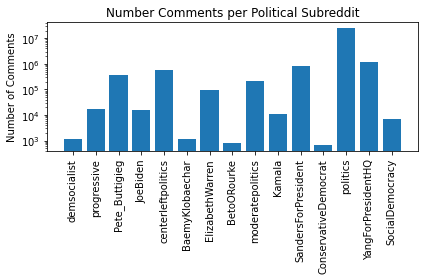

In [27]:
fig = plt.figure()
plt.yscale('log')
plt.title('Number Comments per Political Subreddit')

plt.ylabel('Number of Comments')
plt.bar(wdf["subreddit"],wdf["count"])
plt.xticks(rotation='vertical')
fig.tight_layout()

## Write Vocabularies and Training Data to File

In [6]:
# Create a temp context for the word and context vocabulary files (which get passed to the word2vecf script)
# temp_dir = tempfile.TemporaryDirectory()
import subprocess
import sys
import os
temp_dir = "/h/224/cameron/Political-Subreddit-Embedding/temp/"
subprocess.run("mkdir -p {}".format(temp_dir), shell=True)

CompletedProcess(args='mkdir -p /h/224/cameron/Political-Subreddit-Embedding/temp/', returncode=0)

In [7]:
# Create temp files
file_data = os.path.join(temp_dir, 'data.txt')
file_wv = os.path.join(temp_dir, 'wv.txt')
file_cv = os.path.join(temp_dir, 'cv.txt')

In [36]:
print("Writing training data to {}...".format(file_data))
training_data.toPandas().to_csv(file_data, header=False, index=False, sep=' ')
training_data.unpersist()

Writing training data to /h/224/cameron/Political-Subreddit-Embedding/temp/data_2.txt...


DataFrame[subreddit: string, author: string, count: bigint]

In [37]:
print("Writing word vocab data to {}...".format(file_wv))
word_vocabulary.toPandas().to_csv(file_wv, header=False, index=False, sep=' ')
word_vocabulary.unpersist()

Writing word vocab data to /h/224/cameron/Political-Subreddit-Embedding/temp/wv_2.txt...


DataFrame[subreddit: string, count: bigint]

In [38]:
print("Writing context vocab data to {}...".format(file_cv))
context_vocabulary.toPandas().to_csv(file_cv, header=False, index=False, sep=' ')
context_vocabulary.unpersist()

Writing context vocab data to /h/224/cameron/Political-Subreddit-Embedding/temp/cv_2.txt...


DataFrame[author: string, count: bigint]

## Train Embedding

In [4]:
from utils import generate_embedding, load_embedding

In [8]:
# Word2vec parameters, using negative sampling
# -alpha 0.18 -negative 35 -sample 0.0043 -size 150
embedding_args = {
                    "param1": "sample", 
                    "param2": "negative", 
                    "file_data": file_data , 
                    "file_wv": file_wv, 
                    "file_cv": file_cv,
                    "size": 150,
                    "alpha": 0.18
                 }
p1_vals = list(map(lambda x : format(x,'.4f'),np.linspace(0.001,0.01,11)))
p2_vals = np.linspace(15,95,11)
embedding_params = [(p1,p2) for p1 in p1_vals for p2 in p2_vals]
embedding_fps = list(map(lambda tp : generate_embedding(p1=tp[0],p2=tp[1],**embedding_args), tqdm(embedding_params)))

In [9]:
embedding_dfs = list(map(lambda e : load_embedding(e,split=False), tqdm(embedding_fps)))

## Evaluate

In [10]:
from ipynb.fs.defs.Analogies import predict_analogies, score
import plotly.graph_objects as go

# def get_score(embedding):
#     pred,actual,_ = predict_analogies(["football","basketball","baseball","hockey","populous_cities"],embedding,frac=0.5,show_prog=False)
#     acc, _ = score(pred,actual)
#     return acc

# assesment_scores = list(map(get_score,tqdm(embedding_dfs)))
assesment_scores = [82.9896907216495,
 71.8213058419244,
 71.30584192439862,
 67.18213058419244,
 74.91408934707904,
 68.90034364261169,
 74.22680412371135,
 77.66323024054984,
 74.39862542955326,
 72.5085910652921,
 75.08591065292096,
 76.97594501718214,
 69.41580756013745,
 68.21305841924399,
 70.27491408934708,
 76.80412371134021,
 68.90034364261169,
 75.60137457044674,
 75.4295532646048,
 69.41580756013745,
 73.02405498281786,
 69.7594501718213,
 75.4295532646048,
 78.52233676975945,
 74.22680412371135,
 78.8659793814433,
 76.28865979381443,
 76.6323024054983,
 73.02405498281786,
 76.1168384879725,
 73.71134020618557,
 76.97594501718214,
 77.31958762886599,
 75.08591065292096,
 74.05498281786942,
 78.52233676975945,
 66.83848797250859,
 75.60137457044674,
 70.27491408934708,
 64.08934707903781,
 66.49484536082474,
 74.74226804123711,
 65.63573883161511,
 72.33676975945016,
 74.74226804123711,
 74.74226804123711,
 0.6872852233676976,
 65.12027491408935,
 74.39862542955326,
 71.30584192439862,
 68.04123711340206,
 80.9278350515464,
 75.08591065292096,
 74.39862542955326,
 64.26116838487972,
 64.08934707903781,
 75.08591065292096,
 72.85223367697594,
 65.63573883161511,
 65.80756013745705,
 73.19587628865979,
 80.06872852233677,
 82.30240549828179,
 75.60137457044674,
 75.60137457044674,
 73.19587628865979,
 80.75601374570446,
 79.89690721649485,
 74.91408934707904,
 7.0446735395189,
 81.09965635738831,
 81.27147766323024,
 73.53951890034365,
 69.58762886597938,
 74.22680412371135,
 25.42955326460481,
 28.350515463917525,
 30.756013745704468,
 28.350515463917525,
 36.25429553264605,
 31.27147766323024,
 79.20962199312714,
 77.66323024054984,
 74.91408934707904,
 67.35395189003437,
 72.85223367697594,
 63.745704467353946,
 77.14776632302406,
 75.08591065292096,
 66.49484536082474,
 77.4914089347079,
 69.0721649484536,
 74.74226804123711,
 72.5085910652921,
 71.8213058419244,
 74.05498281786942,
 71.99312714776632,
 69.0721649484536,
 73.19587628865979,
 73.3676975945017,
 73.71134020618557,
 71.99312714776632,
 75.77319587628865,
 70.79037800687286,
 64.26116838487972,
 71.99312714776632,
 78.69415807560138,
 59.965635738831615,
 82.4742268041237,
 74.05498281786942,
 80.2405498281787,
 41.75257731958763,
 75.94501718213058,
 76.80412371134021,
 74.05498281786942,
 72.16494845360825,
 77.4914089347079,
 72.33676975945016,
 73.3676975945017,
 79.03780068728523,
 76.97594501718214]
assesment_scores

[82.9896907216495,
 71.8213058419244,
 71.30584192439862,
 67.18213058419244,
 74.91408934707904,
 68.90034364261169,
 74.22680412371135,
 77.66323024054984,
 74.39862542955326,
 72.5085910652921,
 75.08591065292096,
 76.97594501718214,
 69.41580756013745,
 68.21305841924399,
 70.27491408934708,
 76.80412371134021,
 68.90034364261169,
 75.60137457044674,
 75.4295532646048,
 69.41580756013745,
 73.02405498281786,
 69.7594501718213,
 75.4295532646048,
 78.52233676975945,
 74.22680412371135,
 78.8659793814433,
 76.28865979381443,
 76.6323024054983,
 73.02405498281786,
 76.1168384879725,
 73.71134020618557,
 76.97594501718214,
 77.31958762886599,
 75.08591065292096,
 74.05498281786942,
 78.52233676975945,
 66.83848797250859,
 75.60137457044674,
 70.27491408934708,
 64.08934707903781,
 66.49484536082474,
 74.74226804123711,
 65.63573883161511,
 72.33676975945016,
 74.74226804123711,
 74.74226804123711,
 0.6872852233676976,
 65.12027491408935,
 74.39862542955326,
 71.30584192439862,
 68.0412

In [12]:
m = np.argmax(assesment_scores)
print("Best performing embedding (sample: {}, negative: {}) had accuracy of {:.2f}%\n\t file_path: {}".format(*embedding_params[m],assesment_scores[m],embedding_fps[m]))

grid = np.array(assesment_scores).reshape((len(p1_vals), len(p1_vals)))

data = go.Heatmap(z=grid,y=np.array(p1_vals).astype(float),colorbar=dict(title="Acc %"),x=p2_vals)

layout = {
    "template": "simple_white",
    "font":{"size": 23},
    "height": 500,
    "width": 750,     
    "xaxis": {"title": "Negative"},
    "yaxis": {"title": "Sample"},
}
fig = go.Figure(data=data,layout=layout)
with open("visualizations/accuracy.pdf", "wb") as f:
    f.write(scope.transform(fig, format="pdf"))
fig.show()
# fig.write_html("visualizations/accuracy.html")

Best performing embedding (sample: 0.0010, negative: 15.0) had accuracy of 82.99%
	 file_path: ./trained_embeddings/vecs_0.0010_15.0.txt


### Reduce to 3 dimensions

In [48]:
best_embedding = embedding_dfs[m]
best_embedding

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
subreddit,,,,,,,,,,,,,,,,,,,,,
SquaredCircle,0.134779,0.043821,-0.011876,-0.066840,0.020694,-0.055040,0.017334,0.004694,-0.082625,0.124690,...,-0.061495,-0.183028,-0.099551,0.031485,-0.040188,0.143292,0.040536,-0.008464,0.041863,-0.172806
AskReddit,0.135559,0.008985,-0.037187,0.000455,0.022365,-0.006085,-0.017524,0.040978,-0.054059,0.069235,...,-0.039066,-0.043172,-0.106157,0.105634,-0.045787,0.063289,0.057239,-0.198356,0.061649,-0.023330
politics,-0.042422,0.024062,-0.165820,0.046046,-0.080393,0.024717,0.044797,0.094564,-0.090970,0.013700,...,0.034073,-0.087685,-0.129094,0.110916,0.047369,0.014214,0.025798,-0.121198,0.155587,-0.057969
memes,0.002449,-0.014680,-0.031889,-0.051864,0.044783,-0.055175,0.063965,0.009760,-0.135631,0.106458,...,0.024190,-0.042757,-0.033878,0.041545,-0.001212,0.076116,0.036539,-0.102034,0.054330,-0.073219
teenagers,0.026058,0.069684,0.024581,0.009624,-0.029134,0.076384,0.078542,0.052331,-0.106552,0.096511,...,0.013686,-0.014345,-0.004146,0.055941,-0.009106,0.085962,0.030374,-0.028468,0.069988,-0.039540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NRV,0.122154,0.130032,-0.243602,-0.032611,-0.038153,-0.014279,-0.065262,-0.001528,-0.099809,-0.018441,...,-0.054521,-0.062958,-0.112747,0.098669,-0.049754,-0.015509,0.117170,-0.216936,0.008118,-0.123790
UTT,0.135902,0.057751,-0.200740,-0.035059,-0.005987,-0.000219,-0.083139,0.033362,-0.119045,0.125617,...,-0.019219,-0.092823,-0.096780,0.095344,-0.114785,0.023995,0.075017,-0.151421,0.048709,-0.065192
MMU,0.119556,0.049138,-0.134668,0.009505,0.023105,-0.025217,-0.026836,-0.026815,-0.198236,0.021817,...,-0.075906,-0.067976,-0.035603,-0.009426,-0.084691,0.068536,-0.040373,-0.134642,0.068508,-0.132696


In [40]:
from sklearn.decomposition import PCA
# PCA Dim Reduction
pca =  PCA(n_components = 3)
three_dim = pd.DataFrame(pca.fit_transform(best_embedding)).set_index(best_embedding.index)
three_dim

,0,1,2
subreddit,,,
SquaredCircle,0.030819,-0.111612,0.037518
AskReddit,0.014519,0.187563,-0.099010
politics,-0.200295,0.298706,0.145213
memes,0.323302,0.005253,0.023049
teenagers,0.446263,0.049542,-0.077641
...,...,...,...
NRV,-0.153201,-0.032724,0.014222
UTT,-0.030660,0.096000,0.023417
MMU,0.094566,0.009991,0.033977


### Visualize Embedding

In [41]:
import plotly.express as px

In [42]:
political_subreddits = ["JoeBiden","Pete_Buttigieg","Kamala",
                        "SandersForPresident","BetoORourke","ElizabethWarren",
                        "BaemyKlobaechar","YangForPresidentHQ","politics","progressive",
                        "demsocialist","SocialDemocracy","centerleftpolitics",
                        "ConservativeDemocrat","moderatepolitics"]
three_dim = three_dim[three_dim.index.isin(political_subreddits)]
three_dim

,0,1,2
subreddit,,,
politics,-0.200295,0.298706,0.145213
YangForPresidentHQ,-0.042358,0.187574,-0.066681
SandersForPresident,-0.055572,0.190718,0.091809
centerleftpolitics,-0.084744,0.130033,-0.073442
Pete_Buttigieg,-0.210284,0.150788,-0.047163
moderatepolitics,-0.099558,0.253639,0.031187
ElizabethWarren,-0.189077,0.153494,-0.061191
progressive,-0.148751,0.208714,0.089648
JoeBiden,-0.132223,0.103071,-0.003763


In [44]:
fig = px.scatter_3d(three_dim, x=0, y=1, z=2,text=three_dim.index,opacity=0.7)
fig.write_html("visualizations/3d_scatter.html")
fig.show()

### Reduce to 2 dimensions

In [47]:
pca =  PCA(n_components = 3)
two_dim = pd.DataFrame(pca.fit_transform(best_embedding)).set_index(best_embedding.index)
two_dim = two_dim[two_dim.index.isin(political_subreddits)]
fig = px.scatter(two_dim, x=0, y=1,text=two_dim.index)
fig.write_html("visualizations/2d_scatter.html")
fig.show()

## Output to tensorboard format

In [54]:
import json
pub_dir = "/h/224/cameron/public_html"

params = embedding_params[m]
name = "{}_{}".format(*params)
# Save Labels separately on a line-by-line manner.
with open(os.path.join(pub_dir, '{}_metadata.tsv'.format(name)), "w") as f:
    for sub in best_embedding.index:
        f.write("{}\n".format(sub))

best_embedding.to_csv(os.path.join(pub_dir, '{}_vecs.tsv'.format(name)),      
        sep='\t',
        index=False,
        header=False,
        encoding='utf-8')

config = {
      "tensorName": name,
      "tensorShape": [
        best_embedding.shape[0],
        best_embedding.shape[1]
      ],
      "tensorPath": os.path.join(pub_dir, '{}_metadata.tsv'.format(name)),
      "metadataPath": os.path.join(pub_dir, '{}_vecs.tsv'.format(name))
    }

with open(os.path.join(pub_dir, "{}_config.json".format(name)), "w+") as text_file:
    text_file.write(json.dumps({"embeddings": [config]}))